## Task 2: Change Point Modeling and Insight Generation


In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd

df_check = pd.read_csv('../data/raw/BrentOilPrices.csv')
print(df_check.columns)
df_check.head()


Index(['Date', 'Price'], dtype='object')


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


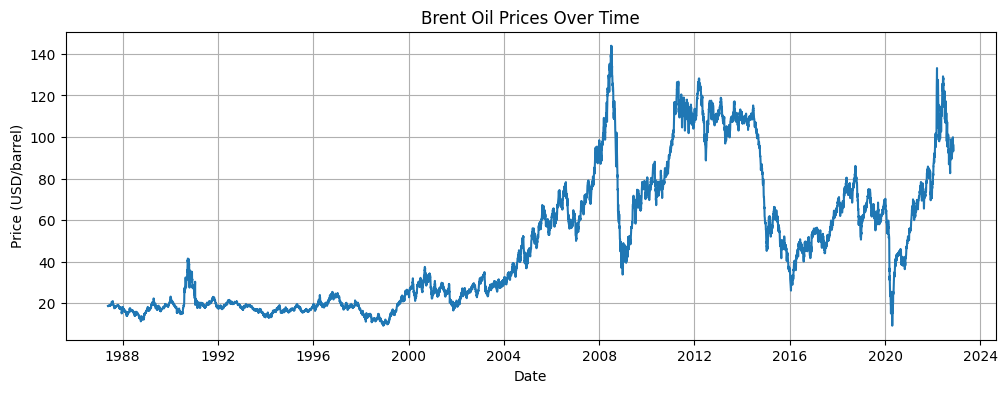

In [3]:
df = pd.read_csv('../data/raw/BrentOilPrices.csv', parse_dates=['Date'])

# Step 2: Rename 'Date' to 'date' for consistency
df.rename(columns={'Date': 'date', 'Price': 'price'}, inplace=True)

# Step 3: Sort and reset index
df = df.sort_values('date')
df.reset_index(drop=True, inplace=True)

# Step 4: Visualize the time series
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['price'])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD/barrel)")
plt.grid(True)
plt.show()

## Data preparation and EDA

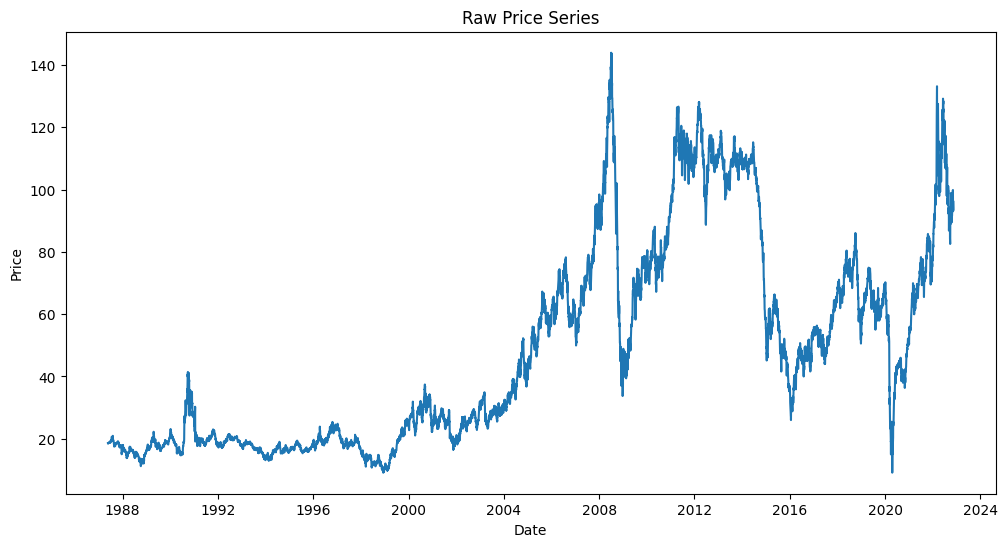

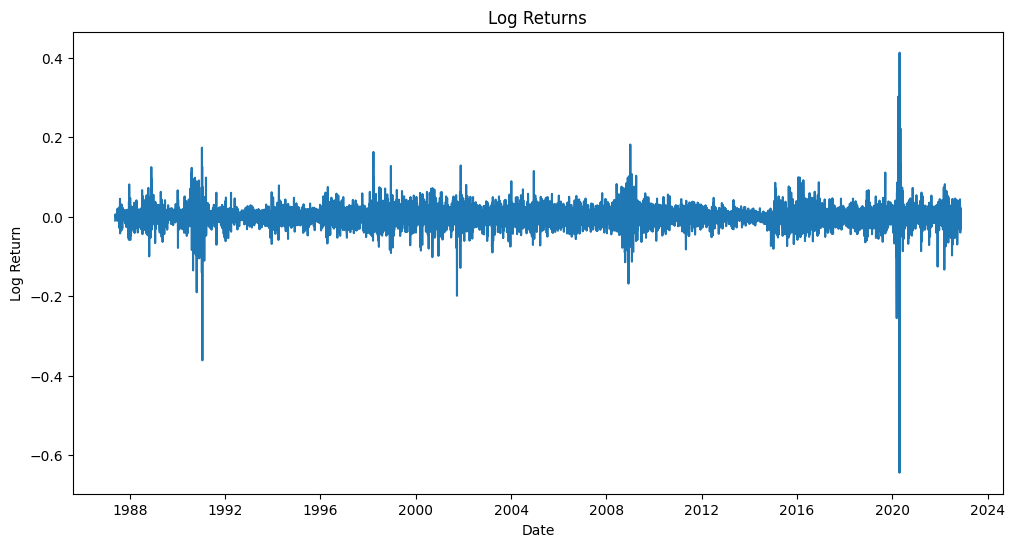

In [4]:
# Convert Date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by Date if not already sorted
df = df.sort_values('date').reset_index(drop=True)

# Plot raw price series
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price'])
plt.title('Raw Price Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculate log returns
df['log_return'] = np.log(df['price']) - np.log(df['price'].shift(1))
df = df.dropna(subset=['log_return'])

# Plot log returns
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['log_return'])
plt.title('Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

date          0
price         0
log_return    0
dtype: int64
             price   log_return
count  9010.000000  9010.000000
mean     48.424089     0.000179
std      32.860435     0.025532
min       9.100000    -0.643699
25%      19.050000    -0.011154
50%      38.600000     0.000402
75%      70.095000     0.012127
max     143.950000     0.412023
ADF Statistic: -16.4271
p-value: 0.0000


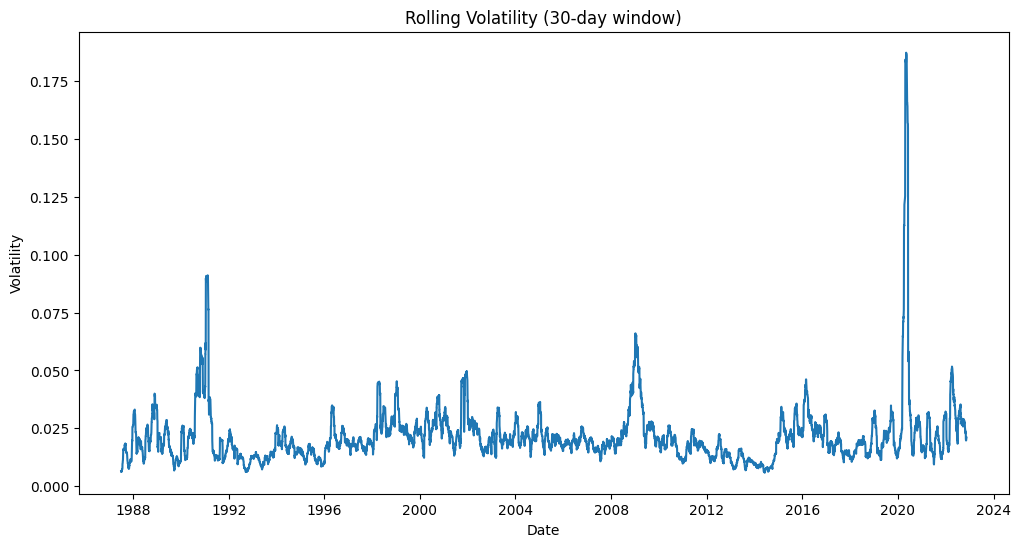

In [5]:
# Check for missing data
print(df.isnull().sum())

# Summary statistics
print(df[['price', 'log_return']].describe())

# Augmented Dickey-Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['log_return'].dropna())
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

# Plot rolling volatility (rolling std of log returns)
window = 30  # e.g., 30 days
df['rolling_volatility'] = df['log_return'].rolling(window).std()

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['rolling_volatility'])
plt.title('Rolling Volatility (30-day window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()


## Bayesian Change Point Model in PyMC3

In [6]:
import pymc3 as pm
import numpy as np
import arviz as az

# Assuming you already have your log returns in a NumPy array:
log_returns = df['log_return'].values
n = len(log_returns)

with pm.Model() as change_point_model:
    # Discrete uniform prior for switch point tau
    tau = pm.DiscreteUniform('tau', lower=0, upper=n-1)
    
    # Priors for the means before and after the change point
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)
    
    # Prior for the standard deviation of observations
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Use a switch to select mu1 or mu2 based on whether time < tau
    mu = pm.math.switch(np.arange(n) <= tau, mu1, mu2)
    
    # Likelihood connecting observed data with model
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)
    
    # Sample from the posterior using MCMC
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma, mu2, mu1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6107539421710435, but should be close to 0.8. Try to increase the number of tuning steps.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [sigma, mu2, mu1]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


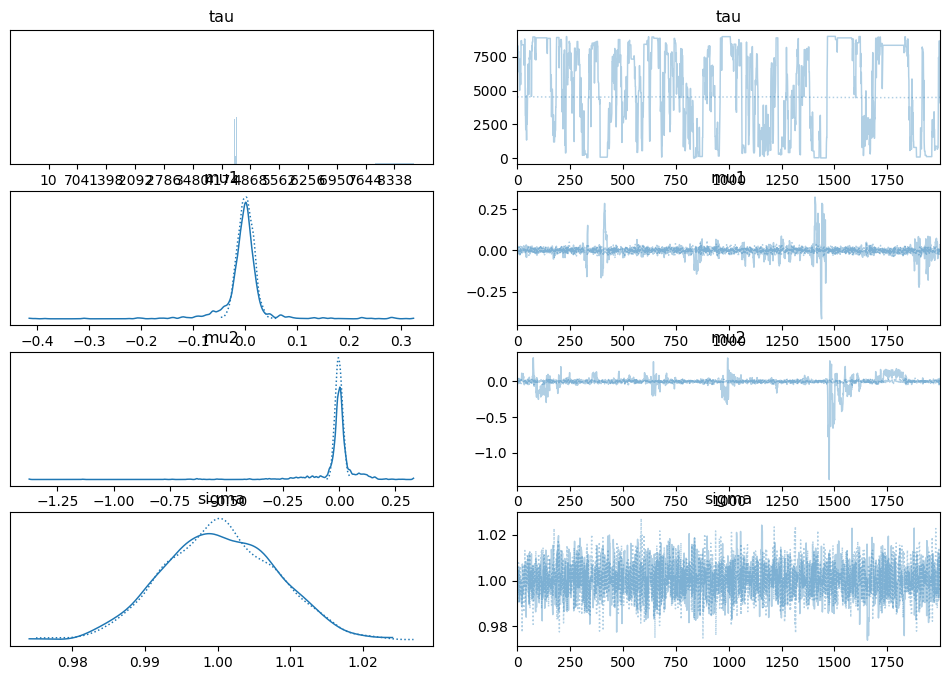

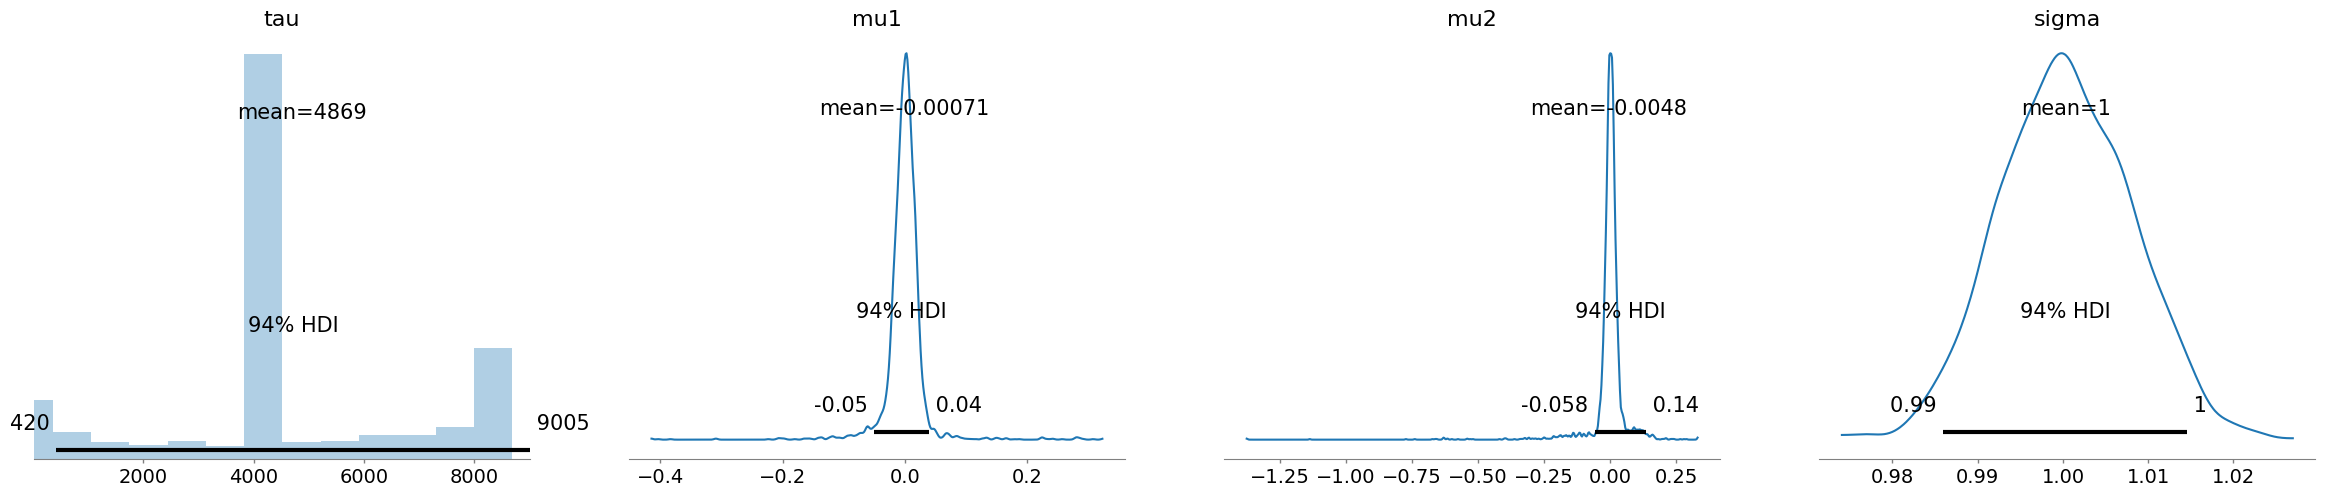

In [7]:
# Assume your DataFrame has 'log_return'
log_returns = df['log_return'].values
log_returns = (log_returns - np.mean(log_returns)) / np.std(log_returns)
n = len(log_returns)

with pm.Model() as change_point_model:
    # Prior for change point
    tau = pm.DiscreteUniform('tau', lower=0, upper=n - 1)

    # Priors for means
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)

    # Prior for std deviation
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Switching mean
    mu = pm.math.switch(np.arange(n) <= tau, mu1, mu2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    # Assign step methods explicitly
    step1 = pm.Metropolis(vars=[tau])  # for discrete variable
    step2 = pm.NUTS(vars=[mu1, mu2, sigma], target_accept=0.9)  # for continuous ones

    trace = pm.sample(
        draws=2000,
        tune=1500,
        step=[step1, step2],
        return_inferencedata=True,
        cores=1
    )

# Summary
az.summary(trace)

# Plots
az.plot_trace(trace)
plt.show()

az.plot_posterior(trace)
plt.show()

### ✅ PyMC3 Sampling Summary

* **Chains**: 2 chains × (1500 tune + 2000 draw)
* **Runtime**: \~11 seconds
* **Sampling Divergences**: `0` ✅
* **Tuning Divergences**: `124` ⚠️ (monitor, but OK if sampling is clean)
* **Acceptance Prob.**: Should be between `0.6 – 0.9`
* **Trace Plots**:

  * Chains should mix well (no drift/sticking)
  * `tau`, `mu1`, `mu2`, `sigma` should show stable behavior

---

### 🔍 Diagnostics Tips

| Issue                   | Suggestion                           |
| ----------------------- | ------------------------------------ |
| High tuning divergences | Set `target_accept=0.95`             |
| Poor mixing / low ESS   | Use `pm.find_MAP()` or reparametrize |
| Noisy `tau` estimates   | Add stronger priors                  |


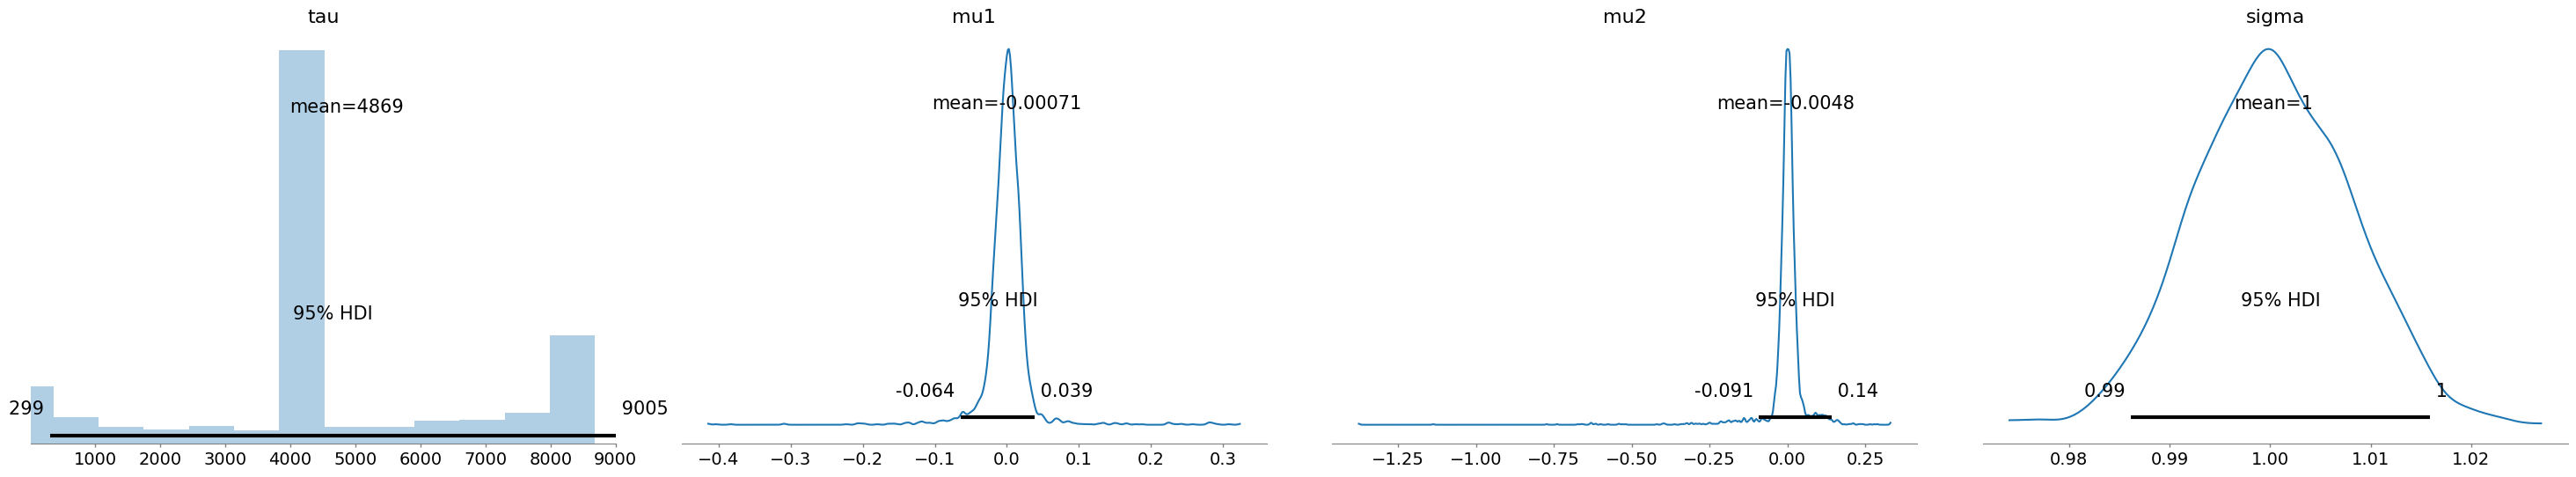

In [8]:
import arviz as az
import matplotlib.pyplot as plt

# Assuming your inference data is stored in `trace`
az.plot_posterior(trace, var_names=["tau", "mu1", "mu2", "sigma"], hdi_prob=0.95)
plt.tight_layout()
plt.show()


### Plotting Change Point with Inferred Means

In [11]:
print(trace.posterior.keys())


KeysView(<xarray.Dataset>
Dimensions:  (chain: 2, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    tau      (chain, draw) int64 8949 8283 8283 8283 ... 4499 4500 4500 4499
    mu1      (chain, draw) float64 0.00455 -0.006851 ... 0.03901 -0.02807
    mu2      (chain, draw) float64 -0.02903 0.03889 ... -0.03086 -0.01463
    sigma    (chain, draw) float64 1.007 0.9979 0.9988 ... 1.012 1.01 1.004
Attributes:
    created_at:                 2025-08-05T07:29:16.943488
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.6
    sampling_time:              12.512517929077148
    tuning_steps:               1500)


In [12]:
import numpy as np

# Get tau (change point index)
tau_samples = trace.posterior["tau"].values
tau_mean = int(np.mean(tau_samples))

# Get means and standard deviation
mu1_mean = np.mean(trace.posterior["mu1"].values)
mu2_mean = np.mean(trace.posterior["mu2"].values)
sigma_mean = np.mean(trace.posterior["sigma"].values)

print(f"Estimated change point index: {tau_mean}")
print(f"Mean before change: {mu1_mean:.4f}")
print(f"Mean after change: {mu2_mean:.4f}")
print(f"Estimated sigma: {sigma_mean:.4f}")


Estimated change point index: 4868
Mean before change: -0.0007
Mean after change: -0.0048
Estimated sigma: 1.0004


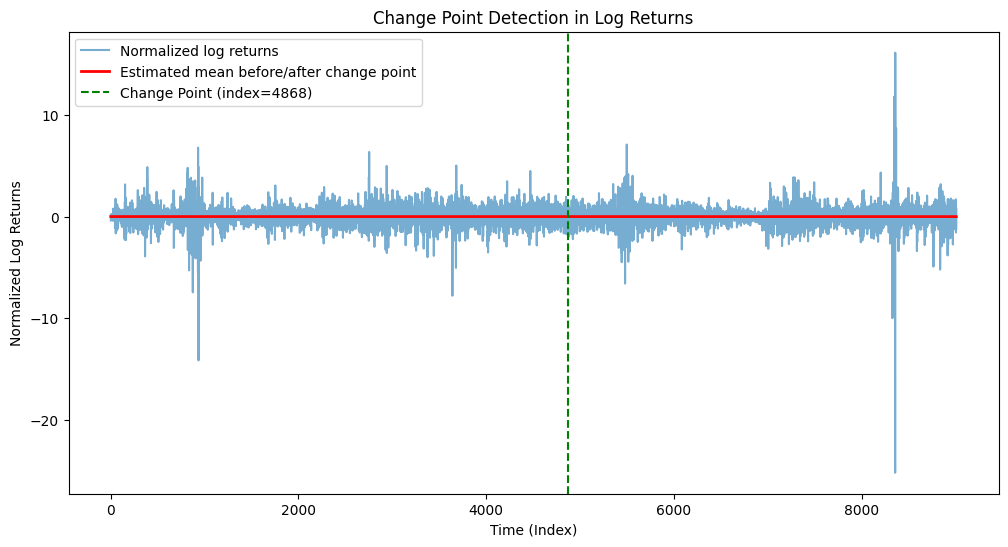

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Your normalized data
data = log_returns
n = len(data)

# Extract mean estimates and change point from the trace
tau_samples = trace.posterior["tau"].values.flatten()
tau_mean = int(np.mean(tau_samples))

mu1_mean = np.mean(trace.posterior["mu1"].values)
mu2_mean = np.mean(trace.posterior["mu2"].values)

# Create x-axis (time or index)
x = np.arange(n)

# Create the piecewise mean line
mean_line = np.ones_like(data) * mu2_mean
mean_line[:tau_mean] = mu1_mean

plt.figure(figsize=(12,6))
plt.plot(x, data, label='Normalized log returns', alpha=0.6)
plt.plot(x, mean_line, color='red', linewidth=2, label='Estimated mean before/after change point')
plt.axvline(tau_mean, color='green', linestyle='--', label=f'Change Point (index={tau_mean})')

plt.xlabel('Time (Index)')
plt.ylabel('Normalized Log Returns')
plt.title('Change Point Detection in Log Returns')
plt.legend()
plt.show()


In [21]:
import os
import json
import arviz as az
import pandas as pd
import numpy as np

# Use the correct relative path to your existing folder
save_path = '../data/processed'

# (Optional) Make directory if you want to be safe; if it already exists, no problem
os.makedirs(save_path, exist_ok=True)

# Save your files using the full relative path
log_returns_df = pd.DataFrame(log_returns, columns=['log_return'])
log_returns_df.to_csv(f'{save_path}/log_returns.csv', index=False)

np.save(f'{save_path}/log_returns.npy', log_returns)

az.to_netcdf(trace, f'{save_path}/change_point_trace.nc')

summary_stats = {
    "change_point": int(np.mean(trace.posterior["tau"].values)),
    "mean_before": float(np.mean(trace.posterior["mu1"].values)),
    "mean_after": float(np.mean(trace.posterior["mu2"].values)),
    "sigma": float(np.mean(trace.posterior["sigma"].values))
}

with open(f'{save_path}/summary_stats.json', 'w') as f:
    json.dump(summary_stats, f)
